In [24]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from skimage.filters import gabor_kernel

# by default, the sketch size is 600
# gabor filter 
def get_gabor_value(u, v, sigma_x, sigma_y, w0, theta):
    x = u* math.cos(theta)-v*math.sin(theta)
    y = u* math.sin(theta)+v*math.cos(theta)    
    res = math.exp(-2*(math.pi**2)*(((x-w0)**2)*sigma_x**2 + (y**2)*sigma_y**2))
    return res 

def get_gabor_filter(theta, side_length = 600, line_width = 0.02, lamb = 0.2, w = 0.13):
    sigma_x = line_width * w
    sigma_y = sigma_x / lamb 
    u = np.arange(-side_length/2, side_length/2)
    v = np.arange(-side_length/2, side_length/2)
    g = np.zeros([side_length,side_length])
    for i in range (side_length):
        for j in range (side_length):
            x = u[j]
            y = v[i]
            g[i][j] = get_gabor_value(x,y,sigma_x,sigma_y,w,theta)
    return g
    
def get_gabor_bank(imgpath, k = 8):
    thetas = np.linspace(0,math.pi, k+1)[:-1]
    index = 0
    for theta in thetas:
        g = get_gabor_filter(theta)
        index = index + 1 
        plt.savefig("%stheta=%02d.png" % (imgpath, index))

# gabor response 
# frequency method of the article 
def get_gabor_response1(theta, img, w0):
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    g = get_gabor_filter(theta,w = w0)
    response_fft = np.multiply(img_fft,g)
    response = np.fft.ifft2(np.fft.ifftshift(response_fft))
    return np.abs(response)
# internal method of the skimage
def get_gabor_response2(theta,img,w0):
    kernel = gabor_kernel(w0, theta)
    new_img = cv2.filter2D(img,-1,np.real(kernel),borderType= cv2.BORDER_CONSTANT)
    return new_img

# feature extraction 
def get_feature_vector(image,k,n,samples):
    # k the number of orientation
    # image : the original image (gray,single-channel)
    # n: number of tails 
    # samples: samples*samples number of points to sample
    thetas = np.linspace(0,math.pi, k+1)[:-1]
    responses = []
    for theta in thetas:
        res_image =  get_gabor_response2(theta, image, 0.13)
        res_image = response_mask(res_image, image)
        responses.append(res_image)
        #plt.imshow(res_image)
        #plt.show()
    feature = []
    points = get_sampling_points(image.shape[0],image.shape[1],samples)
    for point in points:
        patch_feature = []
        for i in range(k):
            res_image = responses[i]
            res_feature = get_patch_response(res_image,point,n,ratio=0.2)
            patch_feature = patch_feature + res_feature
        if np.sum(patch_feature)!=0.0: 
            norm = np.sqrt(np.sum(np.multiply(patch_feature, patch_feature)))
            patch_feature = patch_feature/norm
            feature.append(patch_feature)
            #print(patch_feature)
    return feature
    
def get_single_direction_feature(image,tail):
    # image : the response image 
    # tail : the number of subdivision along one dimension
    h = image.shape[0]
    w = image.shape[1]
    h_len = int(h/tail)
    w_len = int(w/tail)
    response = []
    for i in range (tail):
        for j in range (tail):
            sub_image = image[i*h_len:(i+1)*h_len,j*w_len:(j+1)*w_len]
            sub_res = np.sum(sub_image)
            response.append(sub_res)
    return response
    
def response_mask(res_img, ori_img):
    min_x = 0
    min_y = 0
    max_x = 0
    max_y = 0
    for i in range(ori_img.shape[0]):
        flag = False
        for j in range(ori_img.shape[1]):
            if ori_img[i][j]< 5:
                min_y = i
                flag = True
                break
        if flag:
            break
    for i in range(ori_img.shape[0]-1,-1,-1):
        flag = False
        for j in range(ori_img.shape[1]):
            if ori_img[i][j]< 5:
                max_y = i
                flag = True
                break
        if flag:
            break
    for i in range(ori_img.shape[1]):
        flag = False
        for j in range(ori_img.shape[0]):
            if ori_img[j][i]< 5:
                min_x = i
                flag = True
                break
        if flag:
            break
    for i in range(ori_img.shape[1]-1,-1,-1):
        flag = False
        for j in range(ori_img.shape[0]):
            if ori_img[j][i]< 5:
                max_x = i
                flag = True
                break
        if flag:
            break
    mask = np.zeros(ori_img.shape)
    mask[min_y:max_y,min_x:max_x] = 1
    return np.multiply(mask,res_img)

# sampling 
def get_sampling_points(h,w,n):
    x_sample = random.sample(range(0,w),n)
    y_sample = random.sample(range(0,h),n)
    return [[i,k] for i in x_sample for k in y_sample]

def get_patch_response(image,point,n,ratio=0.2):
    # image : masked image response 
    # n: number of tails 
    w = image.shape[1]
    h = image.shape[0]
    ratio_x = math.sqrt(ratio)
    patch_x = int(w * ratio_x) 
    patch_y = int(h * ratio_x)
    patch = np.zeros([patch_y,patch_x])
    # coordinates in the original image 
    img_x0 = max(0,int(point[0]-patch_x/2))
    img_x1 = min(w-1,int(point[0]+patch_x/2))
    img_y0 = max(0,int(point[1]-patch_y/2))
    img_y1 = min(h-1,int(point[1]+patch_y/2))
    # coordinates in the patch image 
    patch_x0 = int(patch_x/2 -(point[0]-img_x0))
    patch_x1 = int(patch_x/2 +(img_x1-point[0]))
    patch_y0 = int(patch_y/2 -(point[1]-img_y0))
    patch_y1 = int(patch_y/2 +(img_y1-point[1]))
    patch[patch_x0:patch_x1,patch_y0:patch_y1] = image[img_x0:img_x1,img_y0:img_y1]
    return get_single_direction_feature(patch,n)

""" 
image = cv2.imread("/Users/yingyu/INF574/images/m1004_outfile_1.jpg",cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(image,199,199)
edges = cv2.resize(edges, (600, 600), interpolation=cv2.INTER_CUBIC)
features = get_feature_vector(edges,8,4,12)
print(features)
print(len(features))
"""

' \nimage = cv2.imread("/Users/yingyu/INF574/images/m1004_outfile_1.jpg",cv2.COLOR_RGB2GRAY)\nedges = cv2.Canny(image,199,199)\nedges = cv2.resize(edges, (600, 600), interpolation=cv2.INTER_CUBIC)\nfeatures = get_feature_vector(edges,8,4,12)\nprint(features)\nprint(len(features))\n'

In [28]:
#from gabor_feature import get_feature_vector
import cv2
import pickle
import os
from collections import *
import numpy as np
from sklearn.cluster import KMeans
from sklearn.externals import joblib
_k = 8
_n = 4
_samples = 16
_w0 = 0.13
_folder_views = "images/"
_n_clusters = 50
_model_adresse = 'kmeans.sav'
_histogram_adresse = "original_histograms.pickle"
_features_adresse = "original_features.pickle"
_sketch_name = "sketches/888.png"

def getAllViews():
    l = os.listdir(_folder_views)
    all_views = []
    for i in l:
        all_views.append(_folder_views + i)
    return all_views

def processDatabase():
    features = []
    features_per_objectview = []
    names = []
    basic_views = getAllViews()
    print(basic_views)
    for basic_view in tqdm.tqdm(basic_views[:200]):
        sketch = cv2.Canny(cv2.imread(basic_view, 0), 100, 200)
        if np.sum(sketch) == 0:
            continue
        features_objectview = get_feature_vector(sketch, k=_k, n=_n, samples=_samples)
        features.extend(features_objectview )
        features_per_objectview.append(features_objectview)
        names.append(basic_view)
    kmeans = KMeans(n_clusters=_n_clusters, random_state=0).fit(features)
    joblib.dump(kmeans, _model_adresse)
    features_data = [features, features_per_objectview, names]
    with open(_features_adresse, 'wb') as f:
        pickle.dump(features_data, f)
    
def createHistogram(centers):
    h = Counter()
    for i in centers:
        h[i] += 1
    h = dict(sorted(h.items()))
    return h

def createHistograms(kmeans, names, features_per_objectview):
    histograms = []
    for i in range(len(features_per_objectview)):
        feature_objectview = features_per_objectview[i]
        h = createHistogram(kmeans.predict(feature_objectview))
        h['object'] = names[i]
        histograms.append(h)
    histograms.sort(key=lambda x: [(i, x[i]) for i in x.keys()])
    return histograms

def processSketchHistogram(h,N,f):
    hi_sum = np.sum(list(h.values())[:-1])
    print(hi_sum)
    print(N)
    print(f)
    for j in h.keys(): 
        if j == 'object':
            continue
        if f[j] != 0:
            h[j] = h[j]/hi_sum*np.log(N/f[j])
        else:
            h[j] = 0
    print(h.values())
    h_sum = np.sum(([i**2 for i in list(h.values())[:-1]]))
    print(h_sum)
    for j in h.keys():
        if j == 'object':
            continue
        h[j] = h[j]/h_sum
    return h
    
def saveHistograms(): 
    with open(_features_adresse, 'rb') as f:
        features_data = pickle.load(f)
    features_per_objectview = features_data[1]
    names = features_data[2]
    kmeans = joblib.load(_model_adresse)
    histograms = createHistograms(kmeans, names, features_per_objectview)
    N = len(histograms)
    f = np.zeros(kmeans.n_clusters)
    for h in histograms:
        for j in h.keys():
            print(j)
            if j == 'object':
                continue
            f[j] = (f[j] + 1)
    for j in range(len(histograms)):
        histograms[j] = processSketchHistogram(histograms[j],N,f)
    data = [histograms, N, f]
    with open(_histogram_adresse, 'wb') as f:
        pickle.dump(data, f)
        
def readHistograms():
    with open(_histogram_adresse, 'rb') as f:
        data = pickle.load(f)
    histograms = data[0]
    N = data[1]
    f = data[2]
    return histograms, N, f

def processSketch(N, f, sketch_name=_sketch_name, canny=False):
    if canny:
        sketch = cv2.Canny(cv2.imread(sketch_name, 0), 100, 200)
    else:
        sketch = cv2.imread(sketch_name, 0)
    sketch = cv2.resize(sketch, (600, 600))
    print(sketch)
    features_sketch = get_feature_vector(sketch, k=_k, n=_n, samples=_samples)
    #example = np.random.random([_samples*_samples, _n**2*_k])
    kmeans = joblib.load(_model_adresse)
    print(features_sketch)
    histogram_for_sketch = createHistogram(kmeans.predict(features_sketch))
    print(histogram_for_sketch)
    processed_histogram_for_sketch = processSketchHistogram(histogram_for_sketch, N, f)
    return processed_histogram_for_sketch

def findSimilarity(h1, h2):
    res = 0
    for i in h1.keys():
        if i == 'object':
            continue
        try:
            res = res + h1[i]*h2[i]
        except KeyError:
            pass
    return res

def searchSimilarity(histograms, sketch_histogram):
    nearest = -1
    max_similarity = -1
    h_copy = histograms.copy()
    h_copy.sort(key=lambda x: findSimilarity(x, sketch_histogram))
    return(h_copy)

In [29]:
import tqdm

In [30]:
processDatabase()

  0%|          | 0/200 [00:00<?, ?it/s]

['images/m60_outfile_8.jpg', 'images/m494_outfile_19.jpg', 'images/m527_outfile_7.jpg', 'images/m5_outfile_18.jpg', 'images/m1329_outfile_16.jpg', 'images/m713_outfile_16.jpg', 'images/m51_outfile_3.jpg', 'images/m1330_outfile_17.jpg', 'images/m495_outfile_14.jpg', 'images/m1731_outfile_14.jpg', 'images/m1536_outfile_17.jpg', 'images/m1160_outfile_18.jpg', 'images/m1633_outfile_13.jpg', 'images/m1398_outfile_15.jpg', 'images/m1242_outfile_18.jpg', 'images/m898_outfile_16.jpg', 'images/m433_outfile_15.jpg', 'images/m1430_outfile_7.jpg', 'images/m898_outfile_13.jpg', 'images/m976_outfile_12.jpg', 'images/m1029_outfile_12.jpg', 'images/m1453_outfile_15.jpg', 'images/m344_outfile_15.jpg', 'images/m1637_outfile_5.jpg', 'images/m1498_outfile_4.jpg', 'images/m1287_outfile_3.jpg', 'images/m1127_outfile_8.jpg', 'images/m1640_outfile_15.jpg', 'images/m1146_outfile_14.jpg', 'images/m963_outfile_13.jpg', 'images/m1552_outfile_11.jpg', 'images/m1444_outfile_7.jpg', 'images/m1620_outfile_7.jpg', 'im

100%|██████████| 200/200 [03:08<00:00,  1.15it/s]


In [31]:
saveHistograms()

0
1
2
7
10
12
13
14
15
16
18
19
22
25
29
30
32
33
35
36
37
38
40
41
42
43
45
46
47
48
49
object
0
1
2
3
4
7
9
12
13
15
16
18
20
22
23
24
27
28
29
35
36
41
42
45
46
47
48
49
object
0
1
2
4
6
7
8
9
10
11
13
14
15
17
18
20
21
22
24
25
28
32
33
34
35
36
38
39
40
41
44
45
46
47
48
49
object
0
1
2
4
6
7
9
10
11
12
13
14
17
18
19
20
23
29
30
31
32
33
34
35
36
39
40
41
42
43
45
46
48
49
object
0
1
4
5
6
11
12
13
14
15
17
18
20
23
24
25
26
27
28
29
32
34
36
37
40
41
45
46
48
49
object
0
1
2
3
4
5
6
7
8
9
10
13
16
17
19
20
21
25
26
27
28
29
31
32
33
34
35
36
37
38
39
40
41
42
46
47
48
49
object
0
1
2
4
7
9
11
12
13
14
17
18
19
20
25
27
29
32
36
40
41
42
43
45
47
48
49
object
0
1
2
6
7
8
9
10
11
12
13
14
17
18
19
20
22
23
25
26
27
29
30
31
32
33
34
35
36
37
38
40
41
43
44
45
46
48
49
object
0
1
4
7
11
12
13
14
16
17
18
19
20
22
23
27
33
34
35
36
37
38
41
42
45
46
48
49
object
0
1
4
7
8
11
12
17
18
19
20
22
23
26
30
31
32
33
34
36
38
40
41
42
43
44
45
46
47
49
object
0
1
2
4
7
8
9
11
12
13
14
15
1

29
30
32
34
35
36
38
39
40
41
43
45
46
49
object
0
1
3
4
6
7
8
9
10
11
12
13
15
16
18
20
23
24
26
27
29
30
31
32
34
35
36
38
39
40
41
42
44
45
46
48
49
object
0
1
2
4
8
11
12
18
20
23
26
29
30
31
32
33
34
36
40
41
43
44
45
46
48
49
object
0
2
4
6
7
9
10
13
14
18
20
22
23
27
29
30
32
33
34
35
36
38
41
43
46
48
object
0
2
4
5
7
8
9
11
13
14
17
18
19
20
21
22
24
25
27
30
32
36
37
39
40
41
42
43
45
46
47
49
object
0
1
2
4
7
8
9
11
12
13
18
19
23
27
29
30
31
32
35
36
37
39
40
41
43
46
49
object
0
2
4
7
9
10
11
12
14
17
18
19
20
23
25
27
29
32
36
39
40
41
43
45
46
48
49
object
0
1
2
4
5
6
7
8
9
10
12
13
14
15
17
18
20
22
23
24
25
26
27
29
30
32
34
35
36
40
41
42
43
44
45
46
48
object
0
1
2
3
5
8
9
10
12
13
14
16
17
18
19
21
22
23
25
26
27
28
29
31
32
35
36
37
39
40
41
44
45
46
47
48
49
object
0
4
7
8
9
11
12
13
14
15
17
18
19
20
21
23
27
29
30
32
34
35
36
38
39
40
41
43
45
46
48
49
object
0
1
2
3
5
7
8
9
10
12
13
14
16
18
19
21
23
24
26
27
28
31
32
34
36
37
38
39
40
44
45
46
47
48
49
object


200
[116. 120. 144.  73. 155.  91.  84. 140. 104. 139. 113. 141. 151. 159.
 127.  96.  80. 147. 148. 125. 145.  79. 105. 124.  98. 119.  88. 125.
  83. 137. 131.  76. 146. 103. 139. 132. 153. 109. 106. 110. 133. 143.
 123. 127.  82. 151. 147. 100. 150. 128.]
dict_values([0.003560308336220078, 0.03005919567064382, 0.11857152063525242, 0.0033319248317488894, 0.036027483792276514, 0.06236932186112387, 0.029852525377029867, 0.018368465995628264, 0.0029988648931739232, 0.002101853752467074, 0.05429478415022299, 0.009215757436190894, 0.045985712875892225, 0.0027654904793914066, 0.016294723292614343, 0.014006768374149086, 0.04760544975050142, 0.003907431377487715, 0.002192632263321107, 0.0029681717652904932, 0.002012318822021571, 0.013591121187449907, 0.015042199866759783, 0.029169091675060103, 'images/m1104_outfile_7.jpg'])
0.030594366259486055
203
200
[116. 120. 144.  73. 155.  91.  84. 140. 104. 139. 113. 141. 151. 159.
 127.  96.  80. 147. 148. 125. 145.  79. 105. 124.  98. 119.  88. 125.

dict_values([0.00864646310224876, 0.028379201320332816, 0.005214350269397397, 0.05199267075474362, 0.001011477181066627, 0.02812349500111381, 0.004246130284984909, 0.002594946299232794, 0.0043314694454445815, 0.00453118688758489, 0.01803272694527099, 0.0011152282925917158, 0.005462218198281074, 0.010812625716415367, 0.02908859466267159, 0.01221764999084525, 0.0035845844379038287, 0.009325468834240786, 0.0038283764777078846, 0.033173911217179115, 0.06136733489433459, 0.0061808794456727064, 0.04235217133693569, 0.022381125202177887, 0.01395994855161014, 0.03839619151832165, 0.015799723293295258, 0.005775292593926108, 0.001063013671252386, 0.031311917841847656, 0.007558074671856779, 0.026096059556792953, 0.0064756863226394104, 0.019290992506969012, 0.017690438874678242, 0.010037054633325443, 0.00228319105120461, 'images/m563_outfile_8.jpg'])
0.017753731982149544
165
200
[116. 120. 144.  73. 155.  91.  84. 140. 104. 139. 113. 141. 151. 159.
 127.  96.  80. 147. 148. 125. 145.  79. 105. 124

193
200
[116. 120. 144.  73. 155.  91.  84. 140. 104. 139. 113. 141. 151. 159.
 127.  96.  80. 147. 148. 125. 145.  79. 105. 124.  98. 119.  88. 125.
  83. 137. 131.  76. 146. 103. 139. 132. 153. 109. 106. 110. 133. 143.
 123. 127.  82. 151. 147. 100. 150. 128.]
dict_values([0.010587059559916907, 0.015666185368906408, 0.0026413704624745084, 0.04896111046826031, 0.01348446478297497, 0.01478445363476611, 0.03049398034538848, 0.007540796547509739, 0.009055893165022498, 0.0035660077356653645, 0.007059019897763401, 0.01276206341012644, 0.05357554323008386, 0.04253785243885131, 0.012176259825019057, 0.022784371988379244, 0.00588087731688982, 0.009783753725586534, 0.03204838532691639, 0.002152929761459408, 0.005551905599079819, 0.026316197821180085, 0.00845530027619239, 0.025188238921016536, 0.0047060132651756004, 0.06005583186885589, 0.0058246120151940394, 0.0538715425305657, 'images/m910_outfile_10.jpg'])
0.0189597267212179
217
200
[116. 120. 144.  73. 155.  91.  84. 140. 104. 139. 113. 141

127
200
[116. 120. 144.  73. 155.  91.  84. 140. 104. 139. 113. 141. 151. 159.
 127.  96.  80. 147. 148. 125. 145.  79. 105. 124.  98. 119.  88. 125.
  83. 137. 131.  76. 146. 103. 139. 132. 153. 109. 106. 110. 133. 143.
 123. 127.  82. 151. 147. 100. 150. 128.]
dict_values([0.01034658478652082, 0.006021076762884804, 0.01123385650200732, 0.02291927139636818, 0.008851575739625587, 0.016257625818505875, 0.02311713937260474, 0.052159937332647836, 0.007401631956625758, 0.0507367729441349, 0.011292184274244088, 0.01123385650200732, 0.00408814073572053, 0.013850027696873051, 0.013326615538484573, 0.004956074721885043, 0.003271775149304455, 0.02953001757620801, 0.018490623259975632, 0.007151657954164495, 0.04212274579293465, 0.0044257878698127934, 0.02181860644034412, 0.00453042633782332, 'images/m1292_outfile_15.jpg'])
0.011252199935180585
177
200
[116. 120. 144.  73. 155.  91.  84. 140. 104. 139. 113. 141. 151. 159.
 127.  96.  80. 147. 148. 125. 145.  79. 105. 124.  98. 119.  88. 125.
  83

In [32]:
histograms, N, f = readHistograms()

In [33]:
histograms

[{0: 0.45907509113679695,
  1: 0.4305041686147597,
  2: 0.27685058003893187,
  7: 0.6011838211013523,
  10: 3.368102092483161,
  12: 0.47369521988867147,
  13: 1.160043494100051,
  14: 5.740852736537415,
  15: 2.4742438500032,
  16: 1.5444291021532555,
  18: 1.2687988973512654,
  19: 0.3961009633045473,
  22: 0.5430392852793955,
  25: 0.4375566072544017,
  29: 1.2753895442285499,
  30: 0.7131785643107719,
  32: 1.0609043967881475,
  33: 1.118493473386326,
  35: 1.40072167430078,
  36: 0.4515169657132345,
  37: 2.0461220507680515,
  38: 1.070101929623753,
  40: 2.7505593939013773,
  41: 2.544511556164998,
  42: 0.819388370808203,
  43: 0.765447031538322,
  45: 0.23684760994433574,
  46: 2.594734386394842,
  47: 0.5841577571905875,
  48: 0.48489474945743877,
  49: 0.7522271755441609,
  'object': 'images/m602_outfile_4.jpg'},
 {0: 0.797637179641866,
  1: 0.747995562180523,
  2: 0.9620487807240479,
  3: 1.4757937355404727,
  4: 1.4929421132083662,
  7: 1.044549305261068,
  9: 1.59831414594

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


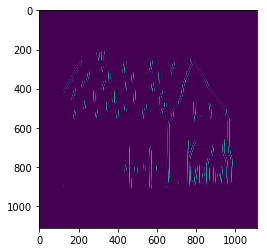

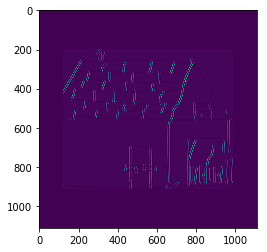

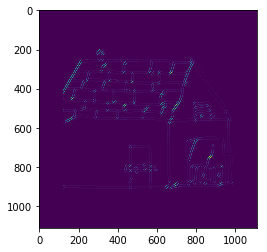

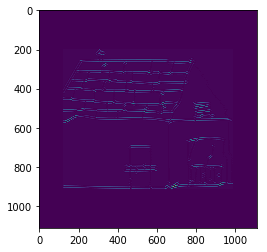

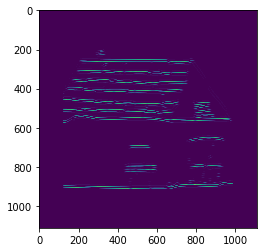

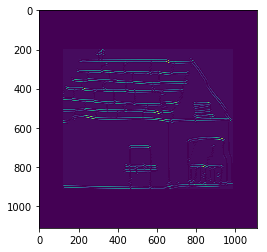

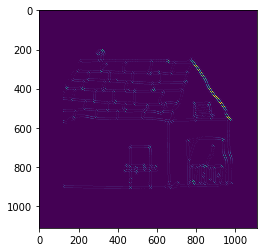

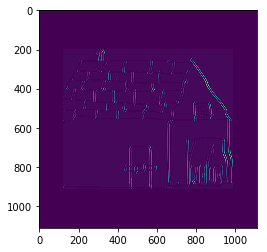

[array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.93777489e-04, 5.35847977e-04, 0.00000000e+00,
       1.22955387e-02, 9.84656865e-02, 1.62137460e-01, 2.81102952e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.11442715e-03, 4.92400844e-03, 3.90300081e-03, 3.59162969e-03,
       1.07234766e-01, 1.95504859e-01, 2.05758382e-01, 1.23570888e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.19336430e-03, 9.48595744e-04, 0.00000000e+00,
       3.68286867e-02, 1.05511363e-01, 1.04236914e-01, 3.96817151e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
     

{0: 0.04173165813484851,
 1: 0.05344161631506404,
 3: 0.6487964835843478,
 4: 1.878212588783052,
 5: 0.2177323581053835,
 7: 0.3740913142054483,
 9: 0.6574434432743158,
 11: 0.18976080674829635,
 14: 0.07354842867831521,
 15: 0.42753293052051233,
 16: 0.6810856810798643,
 17: 0.3338532650787881,
 18: 0.18144363175448625,
 21: 0.44129057206989125,
 22: 0.05022922625016347,
 23: 0.4183731002654737,
 24: 0.14709685735663042,
 25: 0.10886617905269175,
 27: 3.092959782527174,
 28: 0.24870227339818887,
 29: 0.18976080674829635,
 31: 0.2675155794657678,
 32: 0.6487964835843478,
 33: 0.5980970762763812,
 34: 0.5676969231363044,
 36: 0.18976080674829635,
 38: 3.084954291242822,
 39: 0.28719049690365234,
 40: 1.3955598446448891,
 41: 0.08346331626969702,
 43: 0.5676969231363044,
 45: 0.4041411942720569,
 48: 0.8025467383973034,
 49: 0.48921317932382313}

In [9]:
processSketch(N, f)

In [157]:
sketch_histogram = processSketch(N, f)
print(sketch_histogram)
searchSimilarity(histograms, sketch_histogram)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[array([6.95865079e-02, 8.69640805e-02, 0.00000000e+00, 0.00000000e+00,
       2.27974783e-02, 1.19610544e-01, 1.39731943e-04, 0.00000000e+00,
       1.79911229e-01, 2.27839285e-01, 7.55399355e-03, 0.00000000e+00,
       3.45307272e-01, 2.88317811e-01, 2.85010822e-02, 0.00000000e+00,
       8.37671830e-02, 8.04983024e-02, 1.57516009e-03, 0.00000000e+00,
       7.76655548e-02, 1.01762964e-01, 1.53281708e-03, 0.00000000e+00,
       1.82820194e-01, 1.49292996e-01, 4.46718789e-03, 0.00000000e+00,
       2.02344557e-01, 1.77023435e-01, 1.29019161e-02, 0.00000000e+00,
       4.25970713e-02, 1.86944403e-02, 0.00000000e+00, 0.00000000e+00,
       3.67071581e-02, 1.65518839e-02, 2.54058079e-05, 0.00000000e+00,
       4.74919236e-02, 4.19619261e-02, 5.20819062e-04, 0.00000000e+00,
       5.05025118e-02, 5.1

[{1: 0.6279499317745803,
  2: 0.09262409048298419,
  3: 0.08147850855660159,
  4: 0.04164937508994439,
  6: 0.6518280684528127,
  9: 1.5651222789190176,
  14: 0.16295701711320318,
  22: 1.566923391356272,
  24: 0.3542575867624926,
  27: 0.31302445578380356,
  30: 0.9335404275350072,
  34: 0.05097471539303979,
  39: 3.5135242662072628,
  40: 0.28719761175204794,
  41: 2.4443552566980475,
  42: 0.6875803376529566,
  43: 0.2333851068837518,
  44: 0.16295701711320318,
  46: 0.07085151735249852,
  47: 0.18524818096596837,
  49: 1.0465832196243003,
  'object': 'images/m1287_outfile_3.jpg'},
 {0: 2.5392789153863884,
  2: 0.05344748009696307,
  3: 0.047016072618917805,
  4: 0.19226567382745394,
  6: 0.09403214523783561,
  7: 0.11023229554357619,
  8: 0.182738141440081,
  9: 0.12041768891244727,
  10: 0.16572350193098875,
  11: 0.07487035243791645,
  12: 0.5723747527568068,
  14: 0.047016072618917805,
  15: 0.10507314472859532,
  16: 0.07004876315239686,
  17: 0.12265173273360146,
  19: 0.26450

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


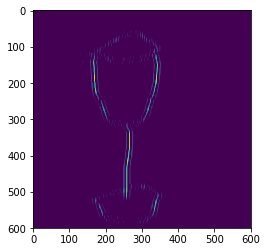

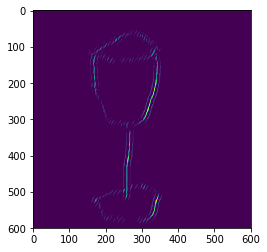

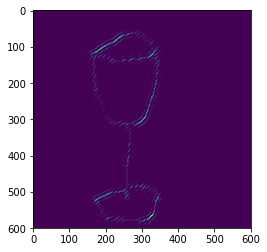

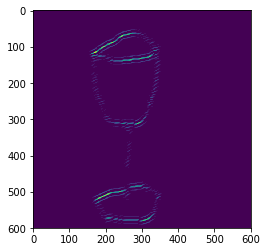

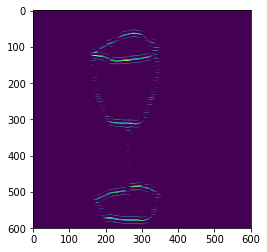

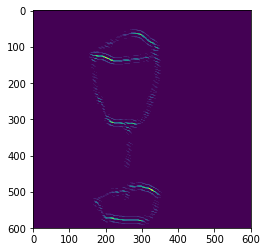

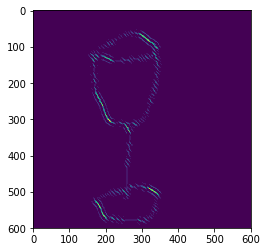

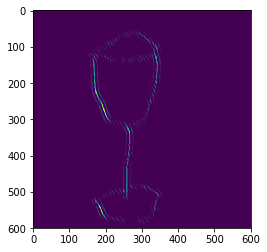

[array([0.46144612, 0.04285464, 0.        , 0.        , 0.05511616,
       0.2343651 , 0.        , 0.        , 0.00716267, 0.01141172,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.23175497, 0.04983521, 0.        , 0.        ,
       0.0492282 , 0.33415692, 0.        , 0.        , 0.01845299,
       0.0292577 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.09888131, 0.05529827, 0.        ,
       0.        , 0.03654177, 0.18337658, 0.        , 0.        ,
       0.04030521, 0.05202043, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.20959924, 0.06306794,
       0.        , 0.        , 0.04394725, 0.10440507, 0.        ,
       0.        , 0.13390557, 0.0976066 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.25639942,
       0.12528608, 0.        , 0.        , 0.08904781, 0.06361425,
       0.        , 0.        , 0.30599183, 0.07654348, 0.    

In [15]:

sketch_histogram = processSketch(N, f, 'sketches/777.png', True)


In [16]:
sketch_histogram

{0: 0.2205875550044796,
 1: 0.11299388526892305,
 2: 0.14892070312837283,
 3: 0.5144167632169793,
 5: 0.07672679953530548,
 6: 0.2810182487247283,
 8: 0.2527383037021718,
 11: 0.45137177433643055,
 12: 1.1333699529625747,
 13: 0.427246469013983,
 14: 0.5442730122489946,
 15: 0.2259877705378461,
 16: 4.320145381786567,
 17: 0.6176451540125428,
 18: 0.34527059790887465,
 19: 0.5054766074043436,
 21: 0.3110131498565683,
 22: 0.0354005973833662,
 23: 0.06318457592554295,
 25: 0.4987241969794856,
 28: 0.2957860170096805,
 30: 1.286041908042448,
 31: 0.5656195822296626,
 33: 0.4917819352682746,
 34: 0.42868063601414935,
 36: 0.10030483874142901,
 37: 0.5144167632169793,
 39: 0.1932060766539931,
 42: 0.15550657492828415,
 43: 0.08573612720282987,
 46: 0.490468244000916,
 49: 0.31030927768353894}

In [17]:
#### print(sketch_histogram)
searchSimilarity(histograms, sketch_histogram)

[{0: 0.03224692600906425,
  1: 0.08259091175088419,
  2: 0.10885099331421805,
  3: 0.25066931361175215,
  4: 0.36283354823854497,
  5: 0.16824635194018922,
  7: 0.08259091175088419,
  8: 0.13855099473383997,
  10: 0.072066545223077,
  13: 0.072066545223077,
  14: 0.28416205390267546,
  15: 0.2477727352526526,
  18: 0.14020529328349102,
  19: 0.04618366491128,
  21: 1.079815804830167,
  22: 0.0646886246866296,
  23: 0.2309183245564,
  24: 0.2273296431221404,
  25: 0.08412317597009461,
  26: 0.18329018568048283,
  27: 3.5849921755041945,
  28: 0.024022181741025665,
  30: 0.1880019852088141,
  32: 1.2533465680587605,
  33: 0.10270269636969209,
  35: 0.3081080891090763,
  37: 0.12533465680587608,
  38: 0.5959521932342077,
  39: 0.040348747288877065,
  40: 0.41081078547876837,
  42: 0.5683241078053509,
  45: 0.19217745392820532,
  48: 0.13780992629032165,
  49: 0.45363032004158366,
  'object': 'images/m1633_outfile_13.jpg'},
 {0: 0.31194028357284664,
  2: 0.7019792566083939,
  5: 0.40688230

In [165]:
hs = [{0:5, 1:1, 5:3}, {0:2, 2:2, 4:2}, {0:3, 2:1, 4:2}, {7:2, 8:2, 9:2}]
searchSimilarity(hs, {0:5, 1:1, 5:3})

[{7: 2, 8: 2, 9: 2},
 {0: 2, 2: 2, 4: 2},
 {0: 3, 2: 1, 4: 2},
 {0: 5, 1: 1, 5: 3}]